In [1]:
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import tensorflow as tf
tfk = tf.keras
tf.keras.backend.set_floatx("float64")
import tensorflow_probability as tfp
tfd = tfp.distributions
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
%matplotlib inline

In [6]:
df = pd.read_csv('scaled_dummied_task.csv')
df.head()

,Input4,Input5,Input6,Input7,Input8,Input9,Input10,Input11,Input12,Input13,...,Input2_PP,Input2_PS,Input2_PUR,Input2_PVC,Input3_LiBF4,Input3_LiCF3SO3,Input3_LiClO4,Input3_LiClO6,Input3_LiI,Input3_LiTFSI
0,0.622395,0.011976,0.606610,0.731429,0.066680,0.451278,0.233309,0.180905,0.044839,0.398350,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.218718,0.674737,0.440686,0.420000,0.141265,0.111310,0.649603,0.809045,0.390311,0.354744,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.647225,0.086764,0.587247,0.345714,0.199027,0.909455,0.761932,0.909548,0.960022,0.429582,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.901855,0.769879,0.973403,0.280000,0.976388,0.074506,0.314636,0.301508,0.060889,0.883324,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.987885,0.076741,0.412419,0.442857,0.609039,0.827567,0.992646,0.698492,0.336337,0.506187,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [7]:
df.columns.values

array(['Input4', 'Input5', 'Input6', 'Input7', 'Input8', 'Input9',
       'Input10', 'Input11', 'Input12', 'Input13', 'Input14', 'Input15',
       'Input16', 'Target', 'Input1_ACN', 'Input1_DMF', 'Input1_DMSO',
       'Input1_THF', 'Input1_acetone', 'Input1_chloroform',
       'Input1_propanol', 'Input2_Nylon', 'Input2_PDMS', 'Input2_PEO',
       'Input2_PMMA', 'Input2_PP', 'Input2_PS', 'Input2_PUR',
       'Input2_PVC', 'Input3_LiBF4', 'Input3_LiCF3SO3', 'Input3_LiClO4',
       'Input3_LiClO6', 'Input3_LiI', 'Input3_LiTFSI'], dtype=object)

In [22]:
len(df.columns)

35

In [19]:
neg_log_likelihood = lambda x, rv_x: -rv_x.log_prob(x)

In [13]:
#Modeled after bnn by Georgi Tancev
#hyperparameters
n_epochs = 50
n_samples = df.shape[0]
n_batches = 10
batch_size = np.floor(n_samples/n_batches)
buffer_size = n_samples

n_train = int(0.9*df.shape[0])
data = tf.data.Dataset.from_tensor_slices((df.drop('Target', axis = 1).values, df['Target'].values))
data = data.shuffle(n_samples, reshuffle_each_iteration=True)
data_train = data.take(n_train).batch(batch_size).repeat(n_epochs)
data_test = data.skip(n_train).batch(1).repeat(n_epochs)

In [25]:
input_shape = len(df.columns) - 1

34

In [27]:
prior = tfd.Independent(tfd.Normal(loc=tf.zeros(len(df.Target), dtype=tf.float64), scale=1.0),
                        reinterpreted_batch_ndims=1)
model = tfk.Sequential([
tfk.layers.InputLayer(input_shape= input_shape, name="input"),
tfk.layers.Dense(10, activation="relu", name="dense_1"),
tfk.layers.Dense(tfp.layers.MultivariateNormalTriL.params_size(
len(df.Target)), activation=None, name="distribution_weights"),
tfp.layers.MultivariateNormalTriL(len(df.Target),
                                  activity_regularizer=tfp.layers.KLDivergenceRegularizer(prior, weight=1/n_batches),
                                  name="output")], name="model")
model.compile(optimizer="adam", loss=neg_log_likelihood)
model.fit(data_train, epochs=n_epochs, validation_data=data_test, verbose=False)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                350       
_________________________________________________________________
distribution_weights (Dense) (None, 180900)            1989900   
_________________________________________________________________
output (MultivariateNormalTr ((None, 600), (None, 600) 0         
Total params: 1,990,250
Trainable params: 1,990,250
Non-trainable params: 0
_________________________________________________________________


In [29]:
samples = 25
iterations = 10
test_iterator = tf.compat.v1.data.make_one_shot_iterator(data_test)
X_true, Y_true, Y_pred = np.empty(shape=(samples, input_shape)), np.empty(shape=(samples, len(df.Target))), np.empty(shape=(samples, len(df.Target), iterations))
for i in range(samples):
    features, labels = test_iterator.get_next()
    X_true[i,:] = features
    Y_true[i,:] = labels.numpy()
    for k in range(iterations):
        Y_pred[i,:,k] = model.predict(features)
        
# Calculate mean and standard deviation.
Y_pred_m = np.mean(Y_pred, axis=-1)
Y_pred_s = np.std(Y_pred, axis=-1)

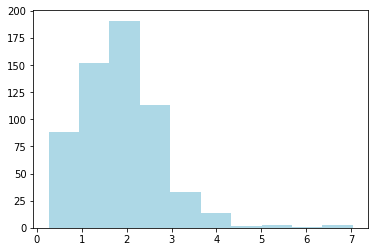

In [47]:
plt.hist(Y_pred_s[4], color = 'lightblue');

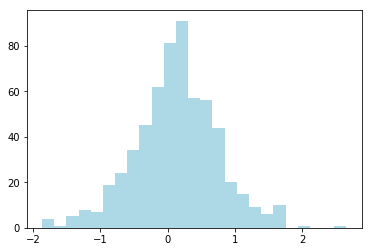

In [46]:
plt.hist(Y_pred_m[4], color = 'lightblue', bins = 25);